In [1]:
%matplotlib inline  

In [2]:
import warnings
warnings.simplefilter('ignore')
import os
import pickle
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

In [3]:
import sys; sys.path.append("../")

In [4]:
from config import bbbp_cls, bace_cls, tox21_cls
from utils import load_data, preprocess
from plot_utils import plot_image_grid


from substruct_utils import (get_act_atoms, get_bond_sets, 
                             find_ccs, atoms_to_bonds, 
                             generate_active_substructs,
                             count_substructs, count_substructz,
                             extract_topk, plot_structs)

import time
import cairosvg
from PIL import Image

Using TensorFlow backend.


In [5]:
#Fix a method
method = "CAM/GradCAM"
#method = "cEB"
method_class = 1

#Only select TPs
true_label = 1
pred_label = 1

#Fix a level for activations
ACTIV_THRES = 0.0

#Number of top results to show
topk = 25

datasets = ["BBBP", "BACE", "TOX21"]
data_dir = "../data"
results_dir = "../results/"
masks_dir = os.path.join(results_dir, "masks")
out_dir = os.path.join(results_dir, "substruct_counts")

#Create tmp dir for writing tmp images
tmp_dir = os.path.join(results_dir, 'tmp')
if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

save_substructs = False

In [6]:
configs = [bbbp_cls, bace_cls, tox21_cls]

### Count frequencies of activated substructures

* Load masks from disk

In [7]:
explain_results = {}
for dataset in datasets:

    #Load masks
    fp = os.path.join(masks_dir, "mask_{}.pickle".format(dataset.lower()))
    with open(fp, 'rb') as fh:
        data = pickle.load(fh) 

    #Extract samples that meet above criteria
    subdata = []
    for m in data:
        for mm in m:
            if (    mm["method"] == method 
                and mm["method_class"] == method_class
                and mm["true_label"] == true_label
                and mm["pred_label"] == pred_label):
                subdata.append(mm)

    activ_substructs = generate_active_substructs(subdata, thresh=ACTIV_THRES)
    counts = count_substructs(activ_substructs)
    explain_results[dataset] = counts

<Figure size 432x288 with 0 Axes>

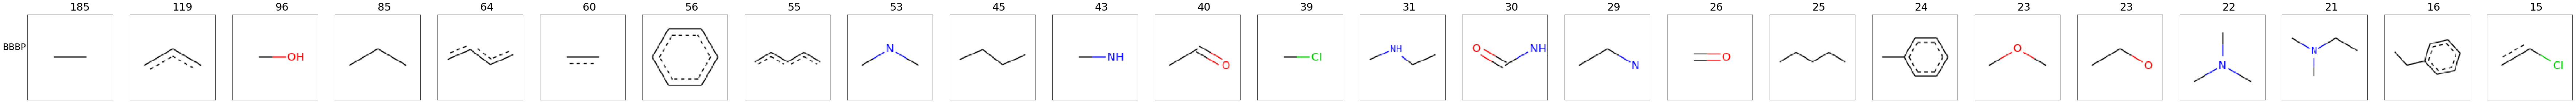

<Figure size 432x288 with 0 Axes>

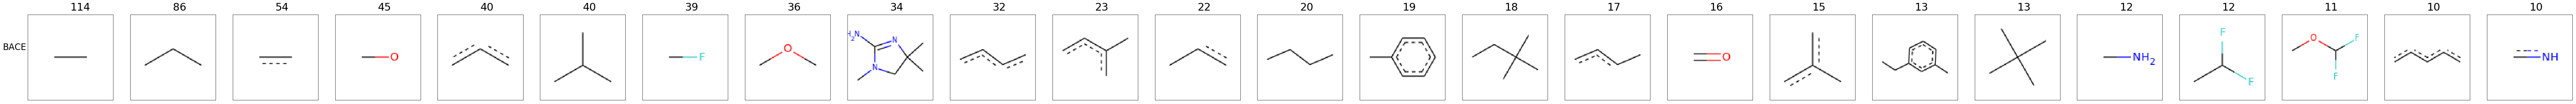

<Figure size 432x288 with 0 Axes>

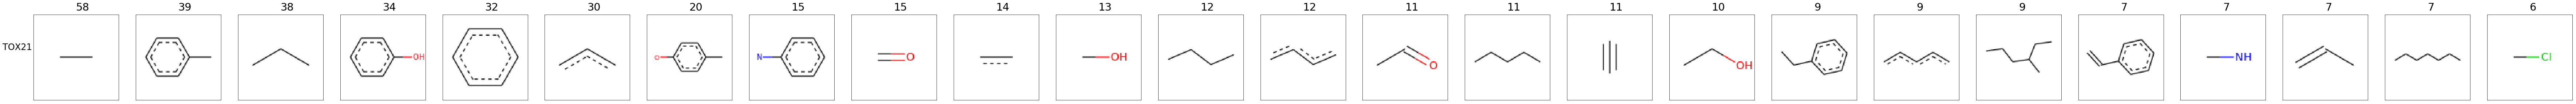

In [8]:
#Plot topk
for dataset in datasets:

    counts = explain_results[dataset]
    sorted_counts = sorted([(k,v) for k,v in counts.items()], reverse=True, key=lambda x:x[1])
    sorted_counts_topk = sorted_counts[:topk]
    ims_arr = [[Draw.MolToImage(k, kekulize=False, size=(100,100)) for k,v in sorted_counts_topk]]
    freqs = [str(v) for k,v in sorted_counts[:topk]]
    row_labels_left = [ (dataset, '')]
    plot_image_grid(ims_arr, row_labels_left=row_labels_left, c=5, 
                             row_labels_right=[], 
                             col_labels=freqs, 
                             super_col_labels=[],
                             col_rotation=0
                        )

The above plots show that simply counting the activated substructures results in mostly non-specific structures (e.g. like the two carbon structure `C-C`). We need a way of filtering to more "specific" structures.

### Given a set of substructures, compute their count in the dataset
Count -> Total number of times that substructure occurs in the data

NOT how many molecules it matches. Count EACH match

In [9]:
#Takes a few minutes..
data_results = {}
for dataset,config in zip(datasets, configs):
    #Load data
    data_fp = os.path.join(config['data_dir'], config['data_fn'])
    raw_data = load_data(data_fp)
    smiles = raw_data["smiles"]
    
    #Get explanation results for this dataset
    res = explain_results[dataset]
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    data_counts = count_substructz(mols, res.keys())
    
    data_results[dataset] = data_counts

100%|██████████| 6193/6193 [00:05<00:00, 1196.16it/s]


### Given a set of substructures, compute their count in the POSITIVE dataset

In [10]:
pos_data_results = {}
for dataset,config in zip(datasets, configs):
    #Load data
    data_fp = os.path.join(config['data_dir'], config['data_fn'])
    raw_data = load_data(data_fp)
    smiles = raw_data["smiles"]
    labels = raw_data["labels"]
    pos_smiles = [s for s,l in zip(smiles, labels) if l[0] == 1]
    
    #Get explanation results for this dataset
    res = explain_results[dataset]
    
    mols = [Chem.MolFromSmiles(s) for s in pos_smiles]
    pos_data_counts = count_substructz(mols, res.keys())
    
    pos_data_results[dataset] = pos_data_counts

100%|██████████| 6193/6193 [00:05<00:00, 1155.84it/s]


### Compute Ratios

In [11]:
ratios = {}
for dataset in datasets:
    explain_ratios = {}
    pos_ratios = {}
    pos_data_counts = pos_data_results[dataset]
    data_counts = data_results[dataset]
    explain_counts = explain_results[dataset]
    substructs = explain_counts.keys()
    for s in substructs:
        explain_ratios[s] = explain_counts[s] / data_counts[s]
        pos_ratios[s] = pos_data_counts[s] / data_counts[s]
        
    ratios[dataset] = {"explanation_ratios": explain_ratios, 
                       "positive_data_ratios": pos_ratios}

# Visualizations

### Plot explanation freq vs. dataset freq

In [12]:
plt.rcParams["font.size"] = plt.rcParamsDefault["font.size"]

Text(0,0.5,'Explain Counts')

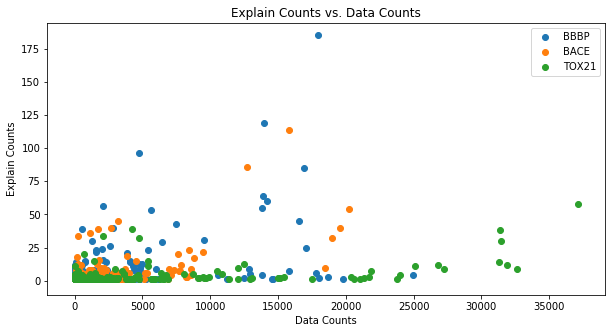

In [13]:
f = plt.figure(figsize=(10,5))
for dataset in datasets:
    data_counts = data_results[dataset]
    explain_counts = explain_results[dataset]

    substructs = explain_counts.keys()
    num_substructs = len(substructs)
    explain_counts_arr = np.zeros(num_substructs)
    data_counts_arr = np.zeros(num_substructs)

    for i,s in enumerate(substructs):
        explain_counts_arr[i] = explain_counts[s]
        data_counts_arr[i] = data_counts[s]
        
    plt.scatter(data_counts_arr, explain_counts_arr, label=dataset)
plt.legend()
plt.title("Explain Counts vs. Data Counts")
plt.xlabel("Data Counts")
plt.ylabel("Explain Counts")

"Explain Counts vs. Data Counts" shows for substructures occurring in explanations, the relationship between how often they naturally occur in the data vs. how often they occur in explanations.

Text(0,0.5,'Explain Counts')

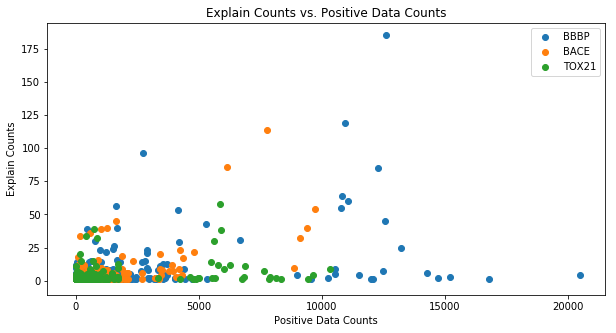

In [14]:
f = plt.figure(figsize=(10,5))
for dataset in datasets:
    pos_data_counts = pos_data_results[dataset]
    explain_counts = explain_results[dataset]

    substructs = explain_counts.keys()
    num_substructs = len(substructs)
    explain_counts_arr = np.zeros(num_substructs)
    pos_data_counts_arr = np.zeros(num_substructs)

    for i,s in enumerate(substructs):
        explain_counts_arr[i] = explain_counts[s]
        pos_data_counts_arr[i] = pos_data_counts[s]

    plt.scatter(pos_data_counts_arr, explain_counts_arr, label=dataset)
plt.legend()
plt.title("Explain Counts vs. Positive Data Counts")
plt.xlabel("Positive Data Counts")
plt.ylabel("Explain Counts")

"Explain Counts vs. Positive Data Counts" shows a related relationship to "Explain Counts vs Data Counts": 

For substructures occurring in explanations, the relationship between how often they naturally occur in POSTIVE data vs. how often they occur in explanations.

### Plot explanation ratio vs. positive ratio

We redo the plots in terms of ratios. Below we redo the second plot "Explain Counts vs. Positive Data Counts" by normalizing each point by the number of times a substructure occurs in the data.

These are defined in 
* https://arxiv.org/pdf/1812.00265.pdf

$$R_e^s = \frac{N^s_e}{N^s_p + N^s_n}$$


$$R_p^s = \frac{N^s_p}{N^s_p + N^s_n}$$

Text(0,0.5,'Explanation Frequency')

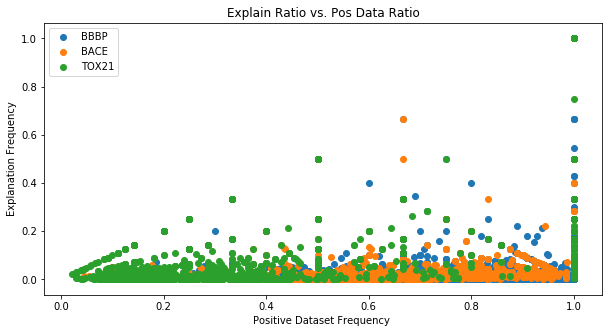

In [15]:
f = plt.figure(figsize=(10,5))
for dataset in datasets:
    explain_ratios = ratios[dataset]['explanation_ratios']
    pos_ratios = ratios[dataset]['positive_data_ratios']

    substructs = explain_ratios.keys()
    num_substructs = len(substructs)
    explain_ratios_arr = np.zeros(num_substructs)
    pos_ratios_arr = np.zeros(num_substructs)

    for i,s in enumerate(substructs):
        explain_ratios_arr[i] = explain_ratios[s]
        pos_ratios_arr[i] = pos_ratios[s]


    plt.scatter(pos_ratios_arr, explain_ratios_arr, label=dataset)
plt.legend()
plt.title("Explain Ratio vs. Pos Data Ratio")
plt.xlabel("Positive Dataset Frequency ")
plt.ylabel("Explanation Frequency")

### Select final results

The ratios are sensitive to rate substructures, e.g. if a substructure only occurs once in the data, then it has the maximum $R_p^s$.

To mitigate this, we filter by a minimum number of observations `MIN_OBS`

In [16]:
Draw.DrawingOptions.atomLabelFontSize = 35
Draw.DrawingOptions.dotsPerAngstrom = 100
Draw.DrawingOptions.bondLineWidth = 3.0
size = (150,150)

#Extract out topk and plot
MIN_OBS = 10
topk = 10

<Figure size 432x288 with 0 Axes>

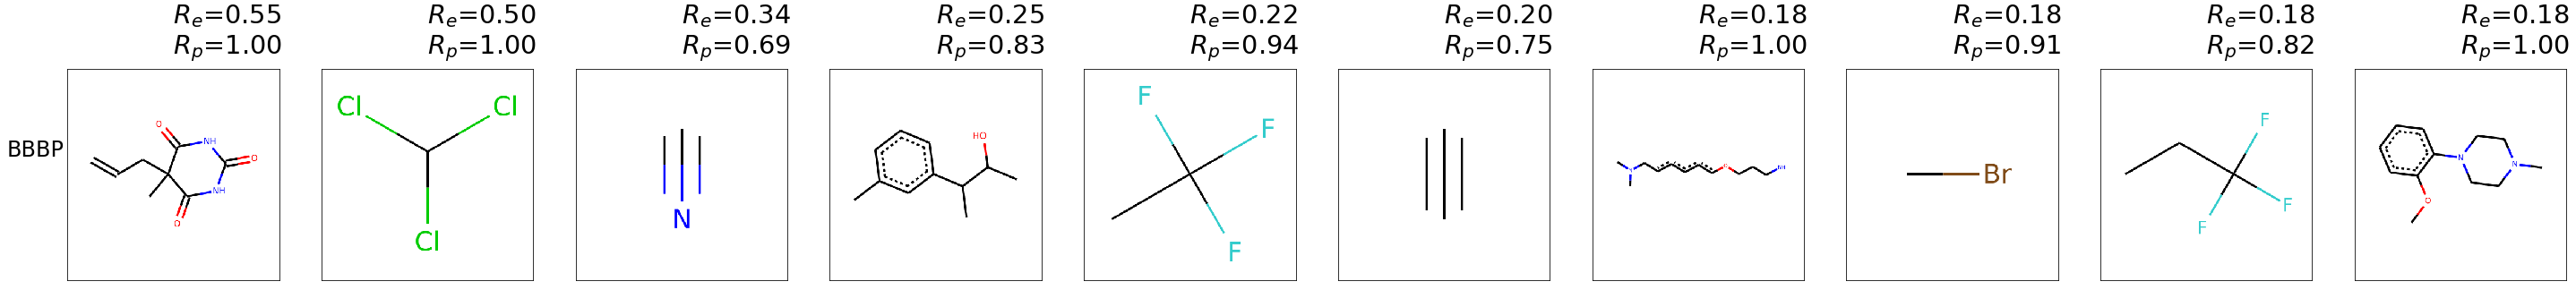

<Figure size 432x288 with 0 Axes>

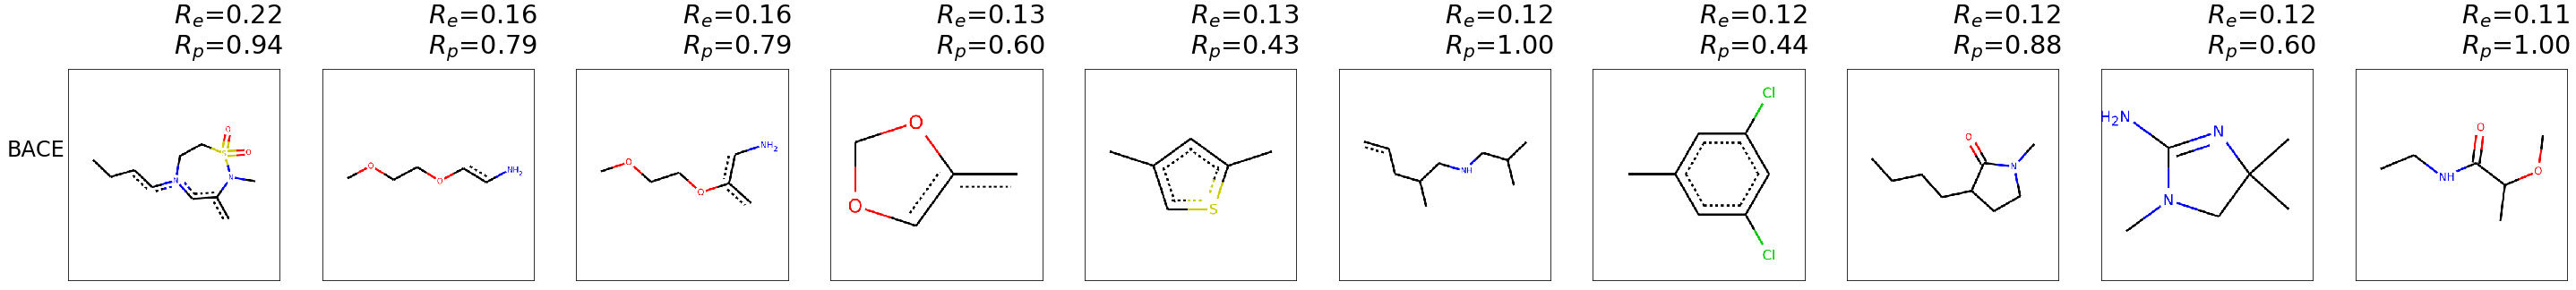

<Figure size 432x288 with 0 Axes>

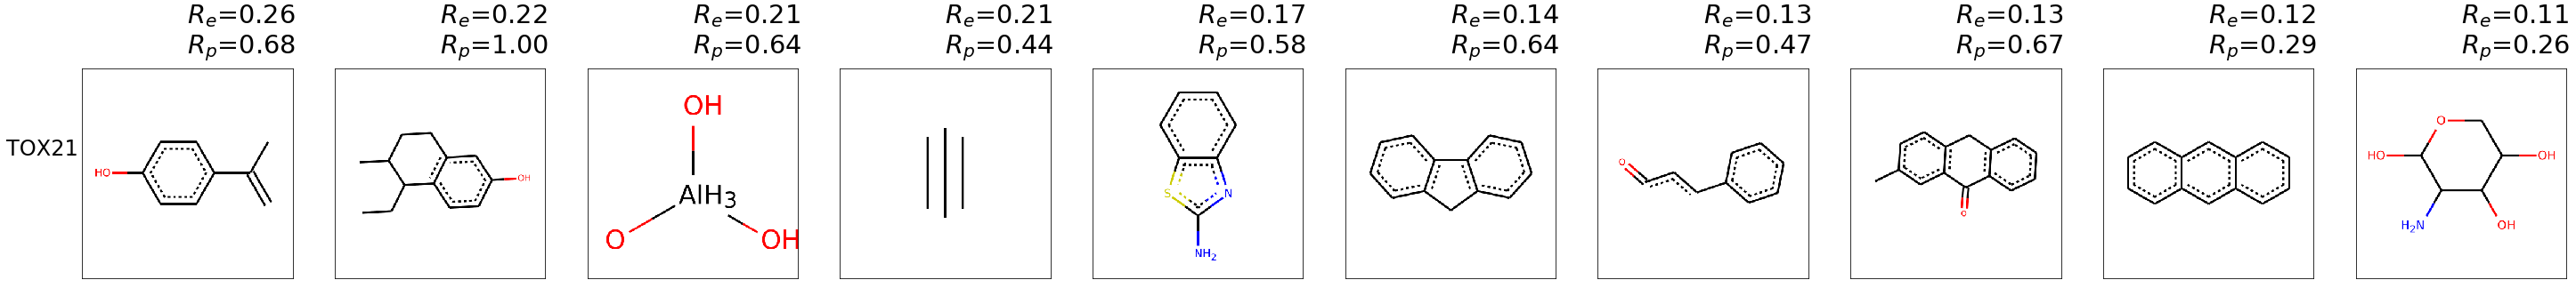

In [17]:
for dataset in datasets:
    #print(dataset)
    #Filter out structures with less than X occurrences
    data_counts = data_results[dataset]
    explain_ratios = {k:v for k,v in ratios[dataset]["explanation_ratios"].items() if data_counts[k] > MIN_OBS}
    pos_ratios = {k:v for k,v in ratios[dataset]["positive_data_ratios"].items() if data_counts[k] > MIN_OBS}
    #Extract topk by explain ratio
    topk_mols = extract_topk(explain_ratios, key=0, topk=topk)
    topk_e_ratios = extract_topk(explain_ratios, key=1, topk=topk)
    topk_pos_ratios = [pos_ratios[k] for k in topk_mols]
    mean_pos_ratio = sum(topk_pos_ratios) / len(topk_pos_ratios)
    #print("{:.2f}".format(mean_pos_ratio))
    topk_data_counts = [data_counts[k] for k in topk_mols]
    labels = ["$R_e$={0:.2f}\n$R_p$={1:.2f}".format(x,y) 
                  for x,y in zip(topk_e_ratios, topk_pos_ratios)]
    ims_arr_ = []
    for i,k in enumerate(topk_mols):
        #Write out as SVG
        tmp_fp = os.path.join(tmp_dir, "{}.svg".format(i))
        Draw.MolToFile(k, tmp_fp, kekulize=False)
        #Read in as PNG
        tmp_fp_ = tmp_fp.replace(".svg", ".png")
        cairosvg.svg2png(url=tmp_fp, write_to=tmp_fp_)
        I = Image.open(tmp_fp_)
        ims_arr_.append(I)
    ims_arr = [ims_arr_]
    row_labels_left = [ (dataset, '')]
    plot_image_grid(ims_arr, row_labels_left=row_labels_left, c=5, 
                             row_labels_right=[], 
                             col_labels=labels, 
                             super_col_labels=[],
                             col_rotation=0
                        )

    time.sleep(1)

### Save

In [18]:
if save_substructs:

    all_results = {"data_counts": data_results, 
                   "positive_data_counts": pos_data_results, 
                   "explanation_counts": explain_results}

    #Save masks
    out_fn = "substruct_counts.pickle"
    out_fp = os.path.join(out_dir, out_fn)
    if not os.path.exists(out_fp):
        with open(out_fp, 'wb') as fh:
            pickle.dump(all_results, fh, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        raise Exception("Substruct file already exists!")